# A/B-test

 Project goals: evaluation of A/B test, including evaluation of methodology and analyze results.<br>
 Sources: technical assignment, user dataset, and a few auxiliary datasets. 

Technical assignment:<br>
Test Name: recommender_system_test<br>
Groups: A (control), B (new payment funnel)<br>
Start Date: 2020-12-07<br>
End Date for New User Enrollment: 2020-12-21<br>
End Date: 2021-01-04<br>
Expected Number of Test Participants: 15% of new users from the EU region<br>
Purpose of the Test: Testing changes related to the implementation of an improved recommender system
Expected Effect: Within 14 days from the moment of registration, users should show an improvement of each metric by at least 5 percentage points:<br>
 - Conversion to viewing product cards — event: product_page<br>
 - Viewing of the cart — event: product_cart<br>
 - Purchases — event: purchase <br>

1. [Uploading data](#loading)
2. [Data preprocessing](#preprocessing)
 * [Data type conversion](#type)
 * [Omissions and duplicates processing](#duplicated)
3. [Evaluation of testing methodology ](#correct_test)
 * [Check data versus Technical assignment](#correct_data)
 * [Testing date check](#correct_time)
 * [Test sample check](#correct_auditorium)
4. [Data Research](#analysis)
 * [User event distribution for test samples](#event_user)
 * [Event distribution in time](#event_day)
 * [Sample User converstion data by group](#conversion)
5. [A/B test results evaluation](#AB_test)
6. [Conclusion](#conclusion)

## Uploading data <a id="loading"></a>

In [25]:
import pandas as pd
from scipy import stats as st
import math as mth
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [26]:
ab_events = pd.read_csv('datasets/final_ab_events.csv')
marketing_events = pd.read_csv('datasets/ab_project_marketing_events.csv')
new_users = pd.read_csv('datasets/final_ab_new_users.csv')
ab_participants = pd.read_csv('datasets/final_ab_participants.csv')

In [27]:
for dataset in [ab_events, marketing_events, new_users, ab_participants]:
    dataset.info()
    display(dataset.head())
    print('*'*50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


**************************************************


Data format is incorrect, hence it should be replaced to the 'datetime' format.

## Data preprocessing <a id="preprocessing"></a>

### Data type conversion  <a id="type"></a>

In [28]:
# conversion
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'], format='%Y-%m-%d %H:%M:%S')
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

#checking
for column in [ab_events['event_dt'], marketing_events['start_dt'], marketing_events['finish_dt'], new_users['first_date']]:
    print(column.dtypes)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### Omissions and duplicates processing  <a id="duplicated"></a>

In [29]:
print('Duplicate check')
for dataset in [ab_events, marketing_events, new_users, ab_participants]:
    print(dataset.duplicated().sum())
    
print('Omission check')
for dataset in [ab_events, marketing_events, new_users, ab_participants]:
    print(dataset.isnull().sum())
    print('*'*50)
    

Duplicate check
0
0
0
0
Omission check
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
**************************************************
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
**************************************************
user_id       0
first_date    0
region        0
device        0
dtype: int64
**************************************************
user_id    0
group      0
ab_test    0
dtype: int64
**************************************************


## Evaluation of testing methodology <a id="correct_test"></a>

### Check data versus Technical assignment <a id="correct_data"></a>

In [30]:
#merge datasets
temp = pd.merge(ab_participants, new_users, left_on='user_id', right_on='user_id', how='left')
ab_test = pd.merge(temp, ab_events, left_on='user_id', right_on='user_id', how='left')

In [31]:
#test type check 
print(f'test type: {ab_test.ab_test.unique()}')
#interface_eu_test date check 
print(ab_test.query('ab_test == "interface_eu_test"')['event_dt'].min())
print(ab_test.query('ab_test == "interface_eu_test"')['event_dt'].max())
#removing interface_eu_test
ab_test = ab_test.query('ab_test == "recommender_system_test"')

test type: ['recommender_system_test' 'interface_eu_test']
2020-12-07 00:02:48
2020-12-30 18:28:55


In [32]:
#region check for new users
print('User regions', ab_test.query('group == "A"| group == "B"')['region'].unique())
print(
    'A/B test new user share in EU -',
    round(ab_test.query('region == "EU"')['user_id'].nunique()/
    new_users.query('region == "EU"')['user_id'].nunique(), 2)
)
# removing new users, not EU
ab_test = ab_test.query('region == "EU"')

User regions ['EU' 'N.America' 'CIS' 'APAC']
A/B test new user share in EU - 0.14


 1. Users outside EU were wrongly included in the test. They need to be deleted.
 2. Based on the technical assignment, the target was 15% of new users in EU. In fact, it's 14%.

### Testing date check <a id="correct_time"></a>

In [33]:
#date checking  
print(f'test user cohort start date  - {ab_test.first_date.min()}')
print(f'test user cohort end date - {ab_test.first_date.max()}')
print(f'first user event date - {ab_test.event_dt.min()}')
print(f'last user event date - {ab_test.event_dt.max()}')
print('-'*20)
# check user lifetime (14 days)
life_time = ab_test.groupby('user_id', as_index=False).agg({'first_date':'max',
                                                            'event_dt':'max'})
print('User zero to 14 days')
display(life_time.query('(event_dt - first_date).dt.days < 14 & event_dt.notnull()')['event_dt'].count())
print('Users with zero events')
display(life_time.isnull()['event_dt'].sum())

test user cohort start date  - 2020-12-07 00:00:00
test user cohort end date - 2020-12-21 00:00:00
first user event date - 2020-12-07 00:05:57
last user event date - 2020-12-30 12:42:57
--------------------
User zero to 14 days


3147

Users with zero events


2870

1. Test/user cohort start date is in line with the technical assignment (2020-12-07). 
2. User cohort end date is in line (2020-12-21). 
3. Last user event date is not in line. It should be 2021-01-04, actual last date in the dataset was 2020-12-30.
4. 2870 users with zero events, so they didn't convert to registration. 
5. 3147 user with lifetime under 14 days. The lifetime is calculated as difference between last user event data and user start date. We keep them as users might open the apps infrequently (e.g., the users open the app 1-2 time a month).

In [34]:
# test date check versus marketing programs
date_start_test = pd.Timestamp('2020-12-07')
date_stop_test = pd.Timestamp('2021-01-04')


def check_date(row):
    if row['start_dt'] <= date_stop_test <= row['finish_dt']:
        return True
    elif row['start_dt'] <= date_start_test <= row['finish_dt']:
        return True
    elif date_start_test <= row['start_dt'] <= date_stop_test:
        return True
    else:
        return False
    
marketing_events[marketing_events.apply(lambda x: check_date(x), axis=1)]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


There were two marketing programs during the testing period. Only one was in the EU region. 
Testing was done during the Christmas / New Year holiday break when user behaviour could be abnormal. 
Those factors can affect the results of the test.

### Test sample check <a id="correct_auditorium"></a>

In [35]:
# check users who participated in the test groups
test_A = ab_test.query('group == "A"')
test_B = ab_test.query('group == "B"')
users_AB = pd.merge(test_A, test_B, left_on='user_id', right_on='user_id', how='inner')['user_id']
print(f'Number of users in both groups {users_AB.nunique()}')

Number of users in both groups 0


In [36]:
# check user overlap with another test
test_r = ab_participants.query('ab_test == "recommender_system_test"')
test_i = ab_participants.query('ab_test == "interface_eu_test"')
test_ri = pd.merge(test_r, test_i, left_on='user_id', right_on='user_id', how='inner')
print('Number of users in both tests', test_ri['user_id'].nunique())

#removing the users participated in both tests
ab_test = ab_test.query('user_id not in @test_ri.user_id')

Number of users in both tests 1602


As timing of two test overlap, the users particiapted in both tests should be removed as the behaviour could be affected by another test.

In [37]:
#checking number of test users 
print('Number of test users', ab_test.query('ab_test == "recommender_system_test"').user_id.nunique())

Number of test users 4749


Expected number of test users was 6000. However, the actual number after filtering is 4749

Группа А - 2713
Группа В - 2036
0.33


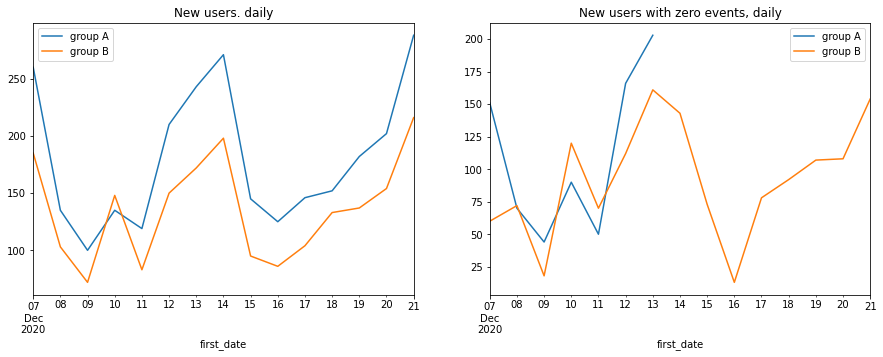

In [38]:
#check of testing groups size and methodology
print('Группа А -', ab_test.query('group == "A"').user_id.nunique())
print('Группа В -', ab_test.query('group == "B"').user_id.nunique())
print(round((ab_test.query('group == "A"').user_id.nunique()
       -ab_test.query('group == "B"').user_id.nunique())
      /ab_test.query('group == "B"').user_id.nunique(), 2))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

(
    ab_test.query('group == "A"')
    .groupby('first_date')['user_id']
    .nunique()
    .plot(label='group A', legend=True, ax=ax1))
(
    ab_test.query('group == "B"')
    .groupby('first_date')['user_id']
    .nunique()
    .plot(label='group B', legend=True, ax=ax1, title = 'New users. daily'))

# Dynamics of users with zero events 
not_active_users = life_time.query('event_dt.isna()')['user_id']

(
    ab_test.query('group == "A" & user_id in @not_active_users')
    .groupby('first_date')['user_id']
    .nunique()
    .plot(label='group A', legend=True, ax=ax2))
(
    ab_test.query('group == "B" & user_id in @not_active_users')
    .groupby('first_date')['user_id']
    .nunique()
    .plot(label='group B', legend=True, ax=ax2, title='New users with zero events, daily'))
plt.show()

Group A is 1.33 larger than group B. Zero event users (non-active) were added to B throughout the period, where as to A inly until December 13th.

## Data Research <a id="analysis"></a>

### User event distribution for test samples <a id="event_user"></a>

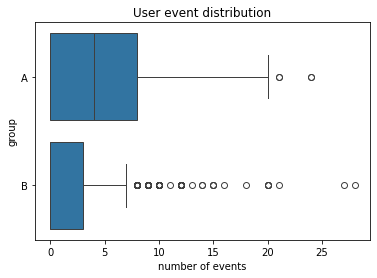

In [39]:
sns.boxplot(data = ab_test.groupby(['group', 'user_id'], as_index=False)['event_name'].count(), 
            x='event_name', 
            y='group')
plt.title('User event distribution')
plt.xlabel('number of events')
plt.show()

User Event distributions among groups are not equal. Group A: 50% users had 0 to 8 events, median 4. Group B: 50% users had 0 to 3 events, median Zero. 

### Event distribution in time  <a id="event_day"></a>

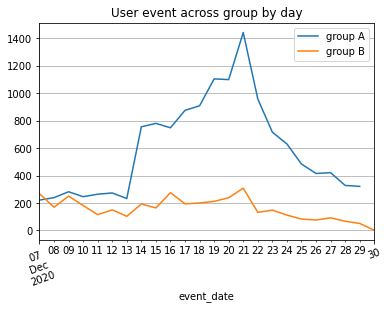

In [40]:
ab_test['event_date'] = pd.to_datetime(ab_test['event_dt'].dt.date)
ab_test.query('group == "A"').groupby('event_date')['event_date'].count().plot(grid=True, label='group A', legend=True)
ab_test.query('group == "B"').groupby('event_date')['event_date'].count().plot(grid=True, label='group B', legend=True)
plt.xticks(rotation=20)
plt.title('User event across group by day')
plt.show()

Distribution of events in time is not similar as well

In [41]:
ab_test

,user_id,group,ab_test,first_date,region,device,event_dt,event_name,details,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,purchase,99.99,2020-12-07
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:56,purchase,4.99,2020-12-25
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:29,product_cart,NaN,2020-12-07
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-25 00:04:57,product_cart,NaN,2020-12-25
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC,2020-12-07 14:43:27,product_page,NaN,2020-12-07
...,...,...,...,...,...,...,...,...,...,...
26285,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:06,product_page,NaN,2020-12-15
26286,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-20 20:01:34,product_page,NaN,2020-12-20
26287,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-14 05:48:50,login,NaN,2020-12-14
26288,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,Android,2020-12-15 20:10:03,login,NaN,2020-12-15


### Sample User converstion data by group  <a id="conversion"></a>

In [42]:
#cumulative conversion for Group A 
group_A = ab_test.query('group == "A"').groupby(['event_name', 'event_date'], as_index=False)['user_id'].nunique()
a_test = ab_test.query('group == "A"')
cumulative_group_A = (
    group_A.apply(lambda x: a_test[np.logical_and(a_test['event_name'] == x['event_name'],
                                                  a_test['event_date'] <= x['event_date'])]
                  .agg({'event_date' : 'max', 'group' : 'max', 'event_name' : 'max', 'user_id':'nunique'}), axis=1)
)
cumulative_group_A = pd.pivot_table(cumulative_group_A, 
                                    index=['group','event_date'], 
                                    columns='event_name', 
                                    values='user_id',
                                    aggfunc='max')

cumulative_group_A.reset_index(inplace=True)

#cumulative new users
cum_new_user_A = (
    group_A.apply(lambda x: a_test[a_test['first_date'] <= x['event_date']]
                   .agg({'first_date': 'max', 'user_id':'nunique'}), axis=1).drop_duplicates()
)

cumulative_group_A = pd.merge(cumulative_group_A, 
                              cum_new_user_A, 
                              left_on='event_date', 
                              right_on='first_date',
                              how = 'outer')


cumulative_group_A.drop('first_date', axis=1, inplace=True)
cumulative_group_A.fillna(cum_new_user_A['user_id'].max(), inplace=True)

cumulative_group_A[['conv_login', 'conv_product_cart', 'conv_product_page', 'conv_purchase']] = (
    cumulative_group_A[['login', 'product_cart', 'product_page', 'purchase']]
          .div(cumulative_group_A['user_id'], axis=0)
)

display(cumulative_group_A.head())

#cumulative conversion for Group B
group_B = ab_test.query('group == "B"').groupby(['event_name', 'event_date'], as_index=False)['user_id'].nunique()
b_test = ab_test.query('group == "B"')
cumulative_group_B = (
    group_B.apply(lambda x: b_test[np.logical_and(b_test['event_name'] == x['event_name'],
                                                  b_test['event_date'] <= x['event_date'])]
                  .agg({'event_date' : 'max', 'group' : 'max', 'event_name' : 'max', 'user_id':'nunique'}), axis=1)
)

cumulative_group_B = pd.pivot_table(cumulative_group_B, 
                                    index=['group','event_date'], 
                                    columns='event_name', 
                                    values='user_id',
                                    aggfunc='max')

cumulative_group_B.reset_index(inplace=True)

#cumulative new users
cum_new_user_B = (
    group_B.apply(lambda x: b_test[b_test['first_date'] <= x['event_date']]
                   .agg({'first_date': 'max', 'user_id':'nunique'}), axis=1).drop_duplicates()
)

cumulative_group_B = pd.merge(cumulative_group_B, 
                              cum_new_user_B, 
                              left_on='event_date', 
                              right_on='first_date',
                              how = 'outer')


cumulative_group_B.drop('first_date', axis=1, inplace=True)
cumulative_group_B['user_id'] = cumulative_group_B['user_id'].fillna(cum_new_user_B['user_id'].max())
purchase_max = cumulative_group_B['purchase'].max()
cumulative_group_B['purchase'] = cumulative_group_B['purchase'].fillna(purchase_max)

cumulative_group_B[['conv_login', 'conv_product_cart', 'conv_product_page', 'conv_purchase']] = (
    cumulative_group_B[['login', 'product_cart', 'product_page', 'purchase']]
    .div(cumulative_group_B['user_id'], axis=0)
)
display(cumulative_group_B.head())

,group,event_date,login,product_cart,product_page,purchase,user_id,conv_login,conv_product_cart,conv_product_page,conv_purchase
0,A,2020-12-07,103,25,66,27,260.0,0.396154,0.096154,0.253846,0.103846
1,A,2020-12-08,170,45,113,45,395.0,0.430380,0.113924,0.286076,0.113924
2,A,2020-12-09,227,60,147,64,495.0,0.458586,0.121212,0.296970,0.129293
3,A,2020-12-10,273,73,171,79,630.0,0.433333,0.115873,0.271429,0.125397
4,A,2020-12-11,343,95,208,90,749.0,0.457944,0.126836,0.277704,0.120160


,group,event_date,login,product_cart,product_page,purchase,user_id,conv_login,conv_product_cart,conv_product_page,conv_purchase
0,B,2020-12-07,114.0,31.0,76.0,47.0,185.0,0.616216,0.167568,0.410811,0.254054
1,B,2020-12-08,149.0,41.0,89.0,52.0,288.0,0.517361,0.142361,0.309028,0.180556
2,B,2020-12-09,205.0,58.0,123.0,63.0,360.0,0.569444,0.161111,0.341667,0.175000
3,B,2020-12-10,234.0,63.0,134.0,70.0,508.0,0.460630,0.124016,0.263780,0.137795
4,B,2020-12-11,247.0,66.0,140.0,72.0,591.0,0.417936,0.111675,0.236887,0.121827


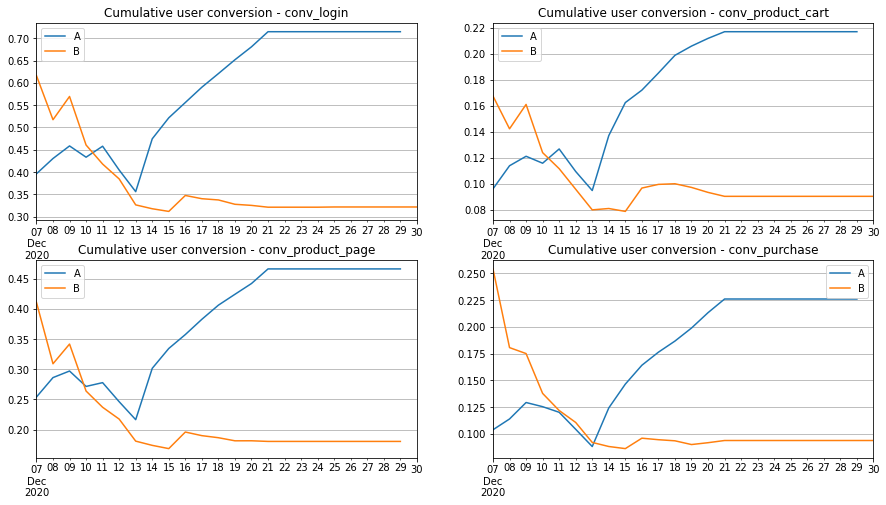

In [43]:
# cumulative user conversion by group, diagram
warnings.filterwarnings("ignore", category=UserWarning)
fig, ax = plt.subplots(2,2, figsize = (15, 8))
for number, column in enumerate(['conv_login', 'conv_product_cart', 'conv_product_page', 'conv_purchase']):
    cumulative_group_A.plot(x='event_date', y=column, label='A', ax=plt.subplot(2, 2, number+1), grid=True)
    cumulative_group_B.plot(x='event_date', y=column, label='B', ax=plt.subplot(2, 2, number+1), grid=True)
    plt.legend()
    plt.title(f'Cumulative user conversion - {column}')
    plt.xticks(rotation=0)
    plt.xlabel('')
plt.show()

Group A conversion jumps around December 14th across metrics, while B does not show that dynamics. This is not typical and might be connected to some outside factors
Conversion across metrics in the conrol group A is around 2x of the test group B

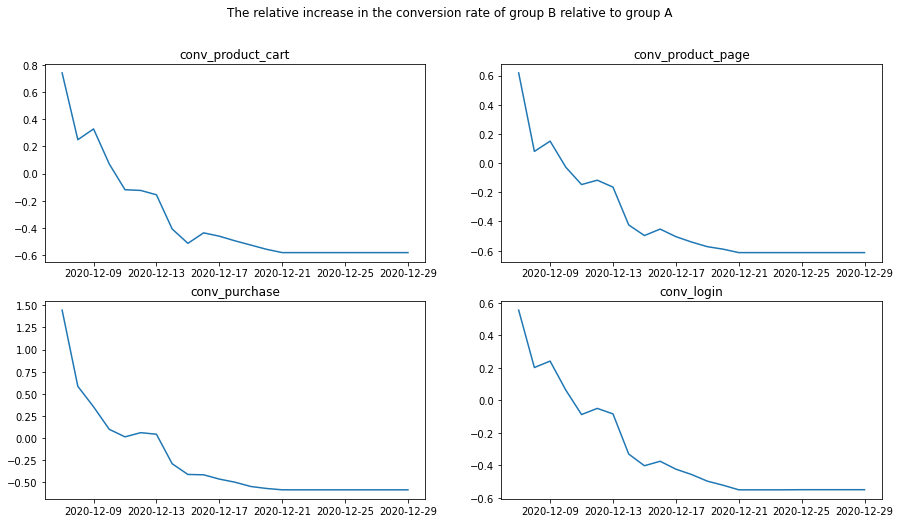

In [44]:
# the cumulative user conversion difference of group B to group A
fig, ax = plt.subplots(2,2, figsize = (15, 8))
for number, column in enumerate(['conv_login', 'conv_product_cart', 'conv_product_page', 'conv_purchase']):
    plt.plot(cumulative_group_B['event_date'], cumulative_group_B[column]/cumulative_group_A[column]-1)
    plt.title(column)
    plt.xticks(rotation=0)
    plt.subplot(2,2,number+1)
    plt.xlabel('')
plt.suptitle('The relative increase in the conversion rate of group B relative to group A')
plt.show()

The ratio relative to the conversion rate in the groups is negative, it decreases throughout the test. This is most likely due to the fact that the groups were not formed correctly. And an additional unaccounted-for factor affects user behavior.

## A/B test results evaluation  <a id="AB_test"></a>

H0: no difference in conversion

H1: conversion is higher by at least 10%:
- to product page `product_page`,
- to product cart — `product_cart`,
- to purchase — `purchase`.

We need to make three tests

In [45]:
alpha = 0.05/3 #added Bonferroni correction for multiple comparisons

for column in ['product_cart', 'product_page', 'purchase']: 
    p1 = cumulative_group_A[column].max()/cumulative_group_A['user_id'].max()
    p2 = cumulative_group_B[column].max()/cumulative_group_B['user_id'].max()
    p_combined = ((cumulative_group_A[column].max() + cumulative_group_B[column].max()) / 
                  (cumulative_group_A['user_id'].max() + cumulative_group_B['user_id'].max()))
    
    difference = p1 - p2
    
    z_value = (
        difference / mth.sqrt(p_combined * (1-p_combined) * 
                              (1/cumulative_group_A['user_id'].count() + 1/cumulative_group_B['user_id'].count()))
    )
    distr = st.norm(0, 1)
    p_value = (1-distr.cdf(abs(z_value)))*2

    print('p-value: ', p_value)

    if p_value < alpha:
        print('Reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')
    print('-'*20)

p-value:  0.23939964313381212
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
--------------------
p-value:  0.03902757725441064
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
--------------------
p-value:  0.22722789211785388
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
--------------------


Differences in conversions across all metrics are not statistically significant (at a significance level of 5%).

## Conclusion <a id="conclusion"></a>

It should be noted that the test groups were not evenly formed:

1. The groups differ in size (Group A is 33% larger than Group B).
2. There is a significant difference in the median number of events per user.
3. The daily event dynamics between the groups also vary significantly. On December 14 and 21, there was an abnormal increase in Group A’s events per user and user conversion (across all metrics).

Therefore, the test results cannot be considered valid. Additionally, the differences in conversions across all metrics are not statistically significant (at a 5% significance level).